In [17]:
# Some necessary packages
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
from shapely.geometry import shape, LineString
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [18]:
# Load the cdata dataset that we saved in practical 1
cdata = pd.read_csv('./dataset/cdata.csv', index_col=0, encoding='gb2312')
# Now create a subset of flows
flows = [440100, 110000, 441900, 320500, 440300, 320200, 130600]
# from cdata, we want the 42 flows that start and end as one of these 7 flows, but not the 7 self flows
# The subset selection has 3 parts: 1) OrigCode in flows; 2) DestCode in flows; 3) Origcode not equal to DestCode.
cdatasub = cdata[cdata['Orig_code'].isin(flows) & cdata['Dest_code'].isin(flows) & (cdata['Orig_code'] != cdata['Dest_code'])]

# Building the Model

In explaining how to run and calibrate spatial interaction models in R, I will adopt the notation used by Taylor Oshan in his excellent primer for running spatial interation models in Python using the SpInt package. The paper is well worth a read and can be found here: http://openjournals.wu.ac.at/region/paper_175/175.html In general, the package is good for spatial interaction modelling, but we ignore it here for the purpose of gettign to grips with the practicalities of the appraoch.

Below is the classic multiplicative gravity model:

1 $$T_{ij} = k \frac{V^{\mu}_{i}W^{\alpha}_{j}}{d^{\beta}_{ij}}$$

This gravity model can be written in the form more familiar from Wilson’s 1971 paper - http://journals.sagepub.com/doi/abs/10.1068/a030001

2 $$T_{ij} = kV^{\mu}_{i}W^{\alpha}_{j}d^{-\beta}_{ij}$$

Text(0.5, 0, 'Flow Distance (m)')

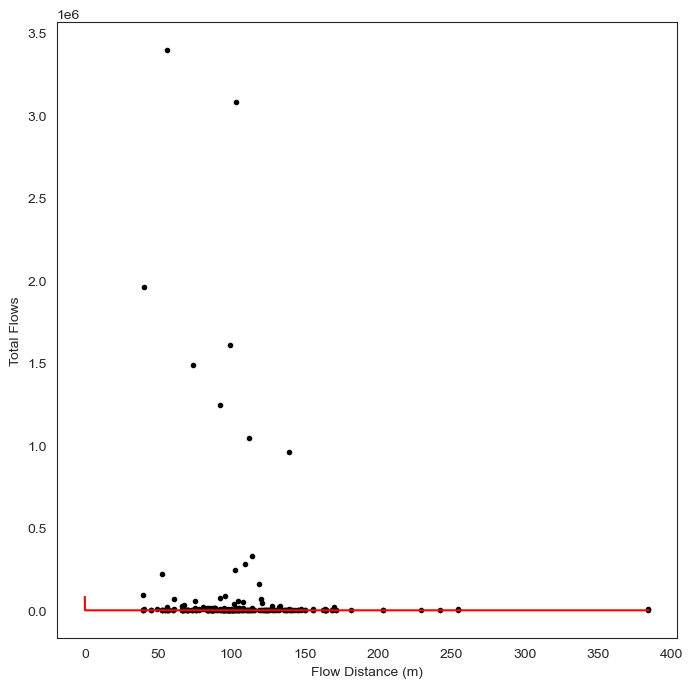

In [19]:
# Now lets create a neat plot of the flows against dist.
f, ax = plt.subplots(1,figsize=(8,8))

# Plot data points
ax.scatter(cdata['dist'],cdata['Flow'],marker='.',color='k')

# now work out the function y = x^-2 - basic inverse power.
xvals = np.geomspace(0.0035,cdata['dist'].max(),1000)
yvals = np.power(xvals,-2.0)
# Now add function line to plot
ax.plot(xvals,yvals,color='r')

# Add some labels
ax.set_ylabel("Total Flows")
ax.set_xlabel("Flow Distance (m)")

Text(0.5, 0, 'Origin Population')

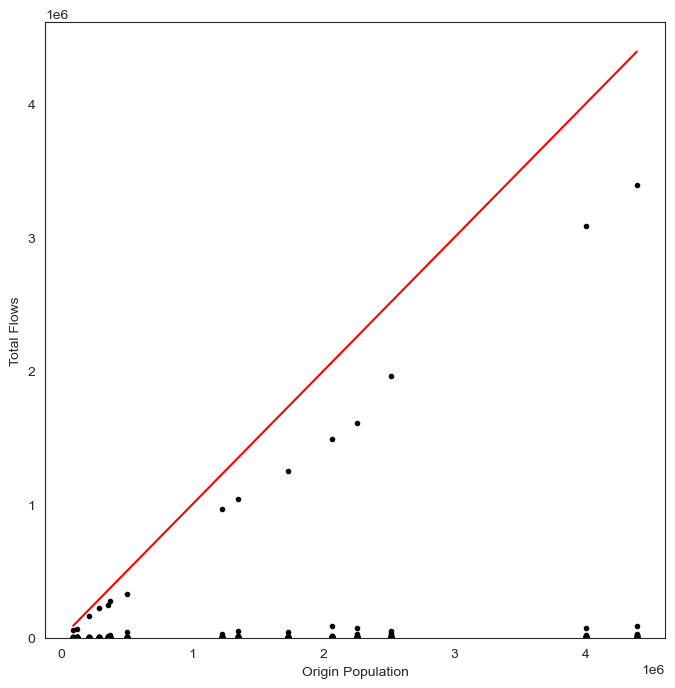

In [20]:
# Now lets create a neat plot of the flows against origin populations.
f, ax = plt.subplots(1,figsize=(8,8))

# Plot data points
ax.scatter(cdata['vi1_origpop'],cdata['Flow'],marker='.',color='k')

# now work out the function y = x - basic linear slope with 0 origin.
xvals = np.linspace(cdata['vi1_origpop'].min(),cdata['vi1_origpop'].max(),100)
yvals = np.power(xvals,1.0)
# Now add function line to plot
ax.plot(xvals,yvals,color='r')

# need to set the ylim to the domain of the origin pops, so we see the full line.
ax.set_ylim(-5000,cdata['vi1_origpop'].max()*1.05)

# Add some labels
ax.set_ylabel("Total Flows")
ax.set_xlabel("Origin Population")

Text(0.5, 0, 'Destination Median Income')

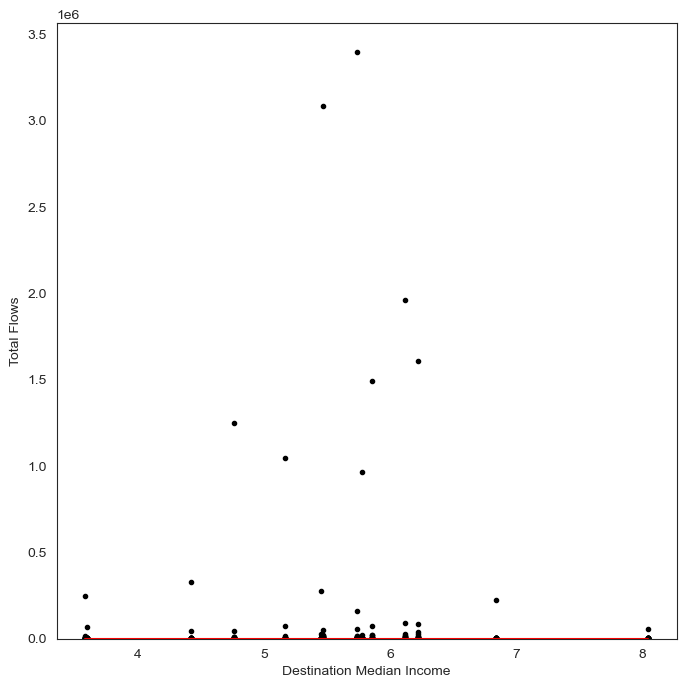

In [21]:
# Now lets create a neat plot of the flows against origin populations.
f, ax = plt.subplots(1,figsize=(8,8))

# Plot data points
ax.scatter(cdata['wj2_destunemp'],cdata['Flow'],marker='.',color='k')

# now work out the function y = x - basic linear slope with 0 origin.
xvals = np.linspace(cdata['wj2_destunemp'].min(),cdata['wj2_destunemp'].max(),100)
yvals = np.power(xvals,1.0)
# Now add function line to plot
ax.plot(xvals,yvals,color='r')

# need to set the ylim to the domain of the origin pops, so we see the full line.
ax.set_ylim(-1000,cdata['Flow'].max()*1.05)

# Add some labels
ax.set_ylabel("Total Flows")
ax.set_xlabel("Destination Median Income")

In [22]:
# Now for some flow estimates
# Set up some variables to hold our parameter values in:
mu = 1.0
alpha = 1.0
beta = -2.0
k = 1.0
T2 = cdatasub['Flow'].sum()

In [23]:
vi1_mu = np.power(cdatasub['vi1_origpop'],mu)
wj2_alpha = np.power(cdatasub['wj2_destunemp'],alpha)
dist_beta = np.power(cdatasub['dist'],beta)
T1 = vi1_mu*wj2_alpha*dist_beta
k = T2/np.sum(T1)

In [24]:
unconstrained_est1 = np.round(k*vi1_mu*wj2_alpha*dist_beta,0)
print(unconstrained_est1.sum())

2087485.0


In [25]:
# Attach these estimates back to cdatasub
cdatasub = cdatasub.assign(est1 = unconstrained_est1)

# Make a pivot table to look at the flow matrix
pd.pivot_table(cdatasub,values='est1',index ='Origin',columns='Destination',fill_value=0,aggfunc=sum,margins=True)

Destination,东莞,保定,北京,广州,无锡,深圳,苏州,All
Origin,,,,,,,,
东莞,0,0,0,254733,0,502301,0,757034.0
保定,0,0,9199,0,0,0,0,9199.0
北京,0,20569,0,0,0,0,0,20569.0
广州,206590,0,0,0,0,51715,0,258305.0
无锡,0,0,0,0,0,0,283205,283205.0
深圳,424329,0,0,57816,0,0,0,482145.0
苏州,0,0,0,0,277028,0,0,277028.0
All,630919,20569,9199,312549,277028,554016,283205,2087485.0


In [26]:
# What about the original flows?
pd.pivot_table(cdatasub,values='Flow',index ='Origin',columns='Destination',fill_value=0,aggfunc=sum,margins=True)

Destination,东莞,保定,北京,广州,无锡,深圳,苏州,All
Origin,,,,,,,,
东莞,0,0,0,795,0,91031,0,91826
保定,0,0,2248,0,0,0,0,2248
北京,0,1439,0,0,0,0,0,1439
广州,2128,0,0,0,0,13084,0,15212
无锡,0,0,0,0,0,0,10670,10670
深圳,4416,0,0,3617,0,0,0,8033
苏州,0,0,0,0,1958058,0,0,1958058
All,6544,1439,2248,4412,1958058,104115,10670,2087486


# How good is my model?

So, looking at the two little matrices above you can see that in some cases the flow estimates aren’t too bad (Barking and Dagenham to Bartnet, for example), but in others they are pretty rubbish (Camden to the City of London, anyone?). Whilst it’s OK to eyeball small flow matrices like this, when you have much larger matrices, we need another solution…

## Testing the "goodness-of-fit"

Well… there are a number of ways but perhaps the two most common are to look at the coefficient of determination ($r^{2}$) or the Square Root of Mean Squared Error (RMSE). You’ve probably come across $r^{2}$ before if you have fitted a linear regression model, but you may not have come across RMSE. There are other methods and they all do more or less the same thing, which is essentially to compare the modelled estimates with the real data. $r^{2}$ is popular as it is quite intuitive and can be compared across models. RMSE is less intuitive, but some argue is better for comparing changes to the same model. Here we’ll do both…

## R-Squared ($r^{2}$)

For the relationship between two variables (e.g. 1 observed and 1 estimated set of flows), the $r^{2}$ is the square of Pearson's product-moment correlation coefficient $r$.

Here we can calculate this very easily using a little function which we write - calcR2()

Using this function we get a value of 0.51 or around 51%. This tells us that our model accounts for about 51% of the variation of flows in the system. Not bad, but not brilliant either.

## Root Mean Squared Error (RMSE)

We can use a similar simple function to calculate the RMSE for our data - here calcRMSE()

The figure that is produced by the RMSE calculation is far less intuitive than the $r^{2}$ value and this is mainly because it very much depends on things like the units the data are in and the volume of data. It can’t be used to compare different models run using different data sets. However, it is good for assessing whether changes to the model result in improvements. The closer to 0 the RMSE value, the better the model.

In [27]:
# Goodness of fit

# Function to compute R^2
def calcR2(obs,est):
    return np.power(np.corrcoef(obs,est),2.0)[0][1]

# Function to compute RMSE
def calcRMSE(obs,est):
    return np.sqrt((np.power((obs - est),2.0)).mean())

print("R squared =", calcR2(cdatasub['Flow'],cdatasub['est1']))
print("RMSE =", calcRMSE(cdatasub['Flow'],cdatasub['est1']))


R squared = 0.027682516238012496
RMSE = 579373.8433813698


# Improving our model: 1 - Calibrating parameters

Now, the model we have run above is probably the most simple spatial interaction model we could have run and the results aren’t terrible, but they’re not great either.

One way that we can improve the fit of the model is by calibrating the parameters on the flow data that we have.

The traditional way that this has been done computationally is by using the goodness-of-fit statistics. If you have the requisite programming skills, you can write a computer algorithm that iteratively adjusts each parameter, runs the model, checks the goodness-of-fit and then starts all over again until the goodness-of-fit statistic is maximised.

This is partly why spatial interaction modelling was the preserve of specialists for so long as acquiring the requisite skills to write such computer programmes can be challenging!

However, since the early days of spatial interaction modelling, a number of useful developments have occurred…

The mathematically minded among you may have noticed that if you take the logarithms of both sides of Equation 2, you end up with the following equation:

5 $$\ln T_{ij} = k + \mu \ln V_{i} + \alpha \ln W_{j} - \beta \ln d_{ij}$$

Those of you who have played around with regression models in the past will realise that this is exactly that - a regression model.


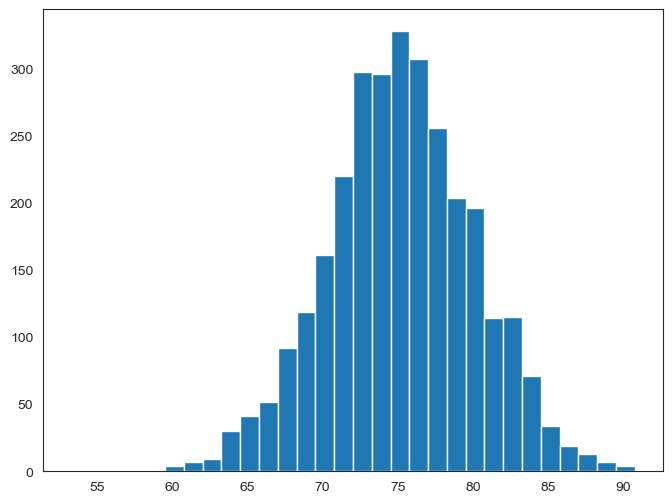

In [28]:
# now we can move onto actually calibrating a model rather than guessing the parameters!
# Here's a normal distribution
f, ax = plt.subplots(1,figsize=(8,6))
ax.hist(np.random.normal(75,5,3000),30);

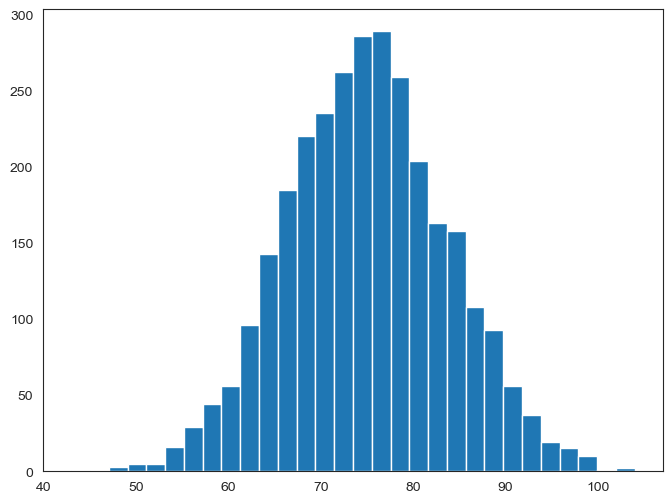

In [29]:
# poisson with mean of 75
f, ax = plt.subplots(1,figsize=(8,6))
ax.hist(np.random.poisson(75,3000),30);

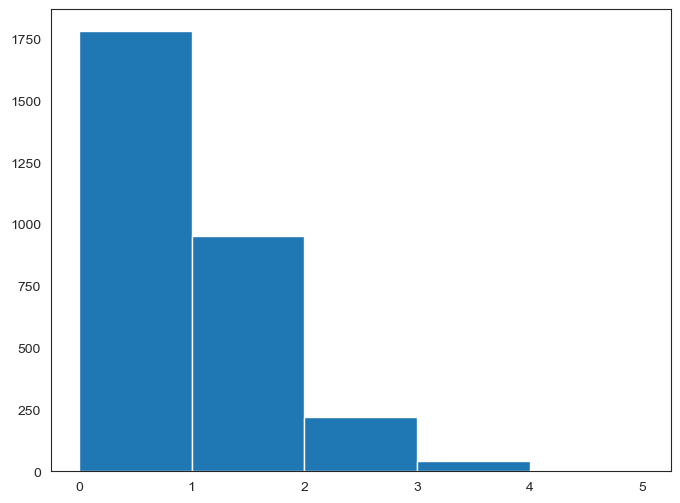

In [30]:
# poisson with mean of 0.5
f, ax = plt.subplots(1,figsize=(8,6))
ax.hist(np.random.poisson(0.5,3000),5);

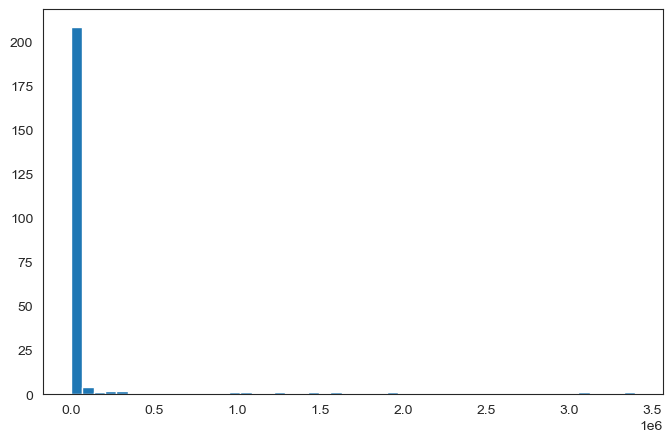

In [31]:
# Here's what our flows look like
# poisson with mean of 0.5
f, ax = plt.subplots(1,figsize=(8,5))
ax.hist(cdata['Flow'],50);

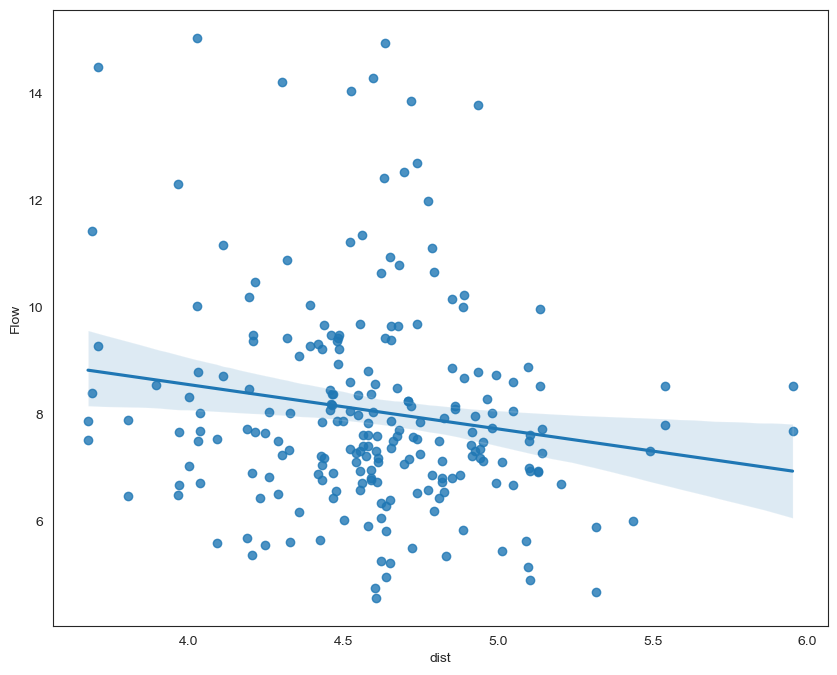

In [32]:
# Now, to estimate the log-log linear model of flows on distance we need to subset out the 0 values.
# Note that R seems to quietly handle this. It's clear that the data is excluded from the domain of the regression line.
# We'll use the seaborn package for this, which doesn't quietly handle zeroes!

# Do the subsetting.
cdata_graph = cdata[(cdata['Flow'] > 0.0) & (cdata['dist'] > 0.0)]

# log the variables
log_total = np.log(cdata_graph['Flow'])
log_dist = np.log(cdata_graph['dist'])

# Now use seaborn to make a nice plot.
import seaborn as sns
sns.set_style('white')
f, ax = plt.subplots(1,figsize=(10,8))
sns.regplot(x = log_dist, y = log_total, ax=ax);